In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Average, Loss
from ignite.contrib.handlers import ProgressBar

import gpytorch
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood

from due.dkl import DKL, GP, initial_values
from due.sngp import Laplace
from due.fc_resnet import FCResNet

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# import os, sys
# import requests
# import h5py

from uci_datasets import Dataset

sns.set()
sns.set_palette("colorblind")

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
data = Dataset("kin40k")
x_train, y_train, x_test, y_test = data.get_split(split=9)

kin40k dataset, N=40000, d=8


In [139]:
x_train.shape

(36000, 8)

In [308]:
data = Dataset("gas")
x_train, y_train, x_test, y_test = data.get_split(split=6)

gas dataset, N=2565, d=128


In [497]:
data = Dataset("protein")
x_train, y_train, x_test, y_test = data.get_split(split=6)

protein dataset, N=45730, d=9


In [562]:
x_train.shape, x_test.shape

((3005, 19), (333, 19))

In [438]:
data = Dataset("keggdirected")
x_train, y_train, x_test, y_test = data.get_split(split=2)

keggdirected dataset, N=48827, d=20


In [67]:
data = Dataset("elevators")
x_train, y_train, x_test, y_test = data.get_split(split=0)

elevators dataset, N=16599, d=18


In [561]:
data = Dataset("skillcraft")
x_train, y_train, x_test, y_test = data.get_split(split=9)

skillcraft dataset, N=3338, d=19


In [ ]:
df = df.astype(float)
Y = df["RMSD"].values.reshape(-1, 1)
X = df[["F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9"]].values

In [ ]:
assert X.shape == (45730, 9)
assert Y.shape == (45730, 1)

In [ ]:
out_dir = "/Users/irwinchay/downloads"

protein_hdf_file = os.path.join(out_dir, 'protein.hdf5')
with h5py.File(protein_hdf_file, 'w') as hf: 
    dset = hf.create_dataset("X", data=X, dtype=np.float64, compression='gzip')
    dset = hf.create_dataset("Y", data=Y, dtype=np.float64, compression='gzip')

In [ ]:
# def make_data(n_samples, noise=0.05, seed=2):
#     # make some random sines & cosines
#     np.random.seed(seed)
#     n_samples = int(n_samples)
    
#     W = np.random.randn(30, 1)
#     b = np.random.rand(30, 1) * 2 * np.pi
    
#     x = 5 * np.sign(np.random.randn(n_samples)) + np.random.randn(n_samples).clip(-2, 2)
#     y = np.cos(W * x + b).sum(0) + noise * np.random.randn(n_samples)
#     return x[..., None], y

In [ ]:
# n_samples = 1e3
# # n_samples = 1e6

# domain = 15

# x, y = make_data(n_samples)
# plt.scatter(x, y)

In [68]:
x_train_real = x_train[:13281] #32000 # 2053   36584    36584     39063   13281    2672   # RE-RUN
y_train_real = y_train[:13281]
y_train_real = y_train_real.squeeze()
x_val = x_train[13281:]
y_val = y_train[13281:]
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [69]:
x_train_real.shape

(13281, 18)

In [7]:
import torch.nn as nn

class IdentityMapping(nn.Module):
    def __init__(self):
        super(IdentityMapping, self).__init__()
    
    def forward(self, x):
        return x


In [75]:
np.random.seed(24)
torch.manual_seed(24) ####################### CHANGE

batch_size = 128

# X_train, y_train = make_data(n_samples)
# X_test, y_test = X_train, y_train

# x_train, y_train, x_test, y_test

ds_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train_real).float(), torch.from_numpy(y_train_real).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True) # suffle 

ds_val = torch.utils.data.TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).float())
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=512, shuffle=False)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=512, shuffle=False)

# steps = 5e3
epochs = 50
print(f"Training with {len(x_train_real)} datapoints for {epochs} epochs")

# Change this boolean to False for SNGP
DUE = True

input_dim = 18 # input di  # 128
features = 1024 # hidden    128
depth = 2   # 4  6
num_outputs = 1 # regression with 1D output
spectral_normalization = True
coeff = 0.95
n_power_iterations = 1
dropout_rate = 0.01

# feature_extractor = FCResNet(
#     input_dim=input_dim, 
#     features=features, 
#     depth=depth, 
#     spectral_normalization=spectral_normalization, 
#     coeff=coeff, 
#     n_power_iterations=n_power_iterations,
#     dropout_rate=dropout_rate
# )

feature_extractor = IdentityMapping()

if DUE:
    n_inducing_points = 100
    kernel = "RBF" ################# change 
    
    initial_inducing_points, initial_lengthscale = initial_values(
            ds_train, feature_extractor, n_inducing_points
    )

    gp = GP(
        num_outputs=num_outputs,
        num_features=input_dim,          # CHANGE features / input_dim
        initial_lengthscale=initial_lengthscale,
        initial_inducing_points=initial_inducing_points,
        kernel=kernel,
    )

    model = DKL(feature_extractor, gp)

    likelihood = GaussianLikelihood()
    elbo_fn = VariationalELBO(likelihood, model.gp, num_data=len(ds_train))
    loss_fn = lambda x, y: -elbo_fn(x, y)
    
    # mse_loss_fn = F.mse_loss
# else:
    # Nothing 
#     num_gp_features = 128
#     num_random_features = 1024
#     normalize_gp_features = True
#     feature_scale = 2
#     ridge_penalty = 1
    
#     model = Laplace(feature_extractor,
#                     features,
#                     num_gp_features,
#                     normalize_gp_features,
#                     num_random_features,
#                     num_outputs,
#                     len(ds_train),
#                     batch_size,
#                     ridge_penalty=ridge_penalty,
#                     feature_scale=feature_scale
#                    )

#     loss_fn = F.mse_loss # MSE

if torch.cuda.is_available():
    model = model.cuda()
    if DUE:
        likelihood = likelihood.cuda()

# learning rate   
lr = 1e-3

parameters = [
    {"params": model.parameters(), "lr": lr},
]

if DUE:
    parameters.append({"params": likelihood.parameters(), "lr": lr})
    
    
optimizer = torch.optim.Adam(parameters)
pbar = ProgressBar()

def step(engine, batch):
    model.train()
    if DUE:
        likelihood.train()
    
    optimizer.zero_grad()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x) # get y
    
    if not DUE:
        y_pred.squeeze_()
    
#     print("y_pred", y_pred)
#     print("y_pred_real", likelihood(y_pred).mean.cpu())
#     print("y", y)
    loss = loss_fn(y_pred, y) # loss
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


def eval_step(engine, batch):
    model.eval() # set to eval
    if DUE:
        likelihood.eval()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)
    
    # eval_mes_loss = mse_loss_fn(y_pred, y) # MSE eval
            
    return y_pred, y

    
trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")
pbar.attach(trainer)

if DUE:
    metric = Loss(lambda y_pred, y: - likelihood.expected_log_prob(y, y_pred).mean())
    # metric = Loss(lambda y_pred, y: F.mse_loss(likelihood(y_pred).mean.cpu(), y))
else:
    metric = Loss(lambda y_pred, y: F.mse_loss(y_pred[0].squeeze(), y))


metric.attach(evaluator, "loss")

@trainer.on(Events.EPOCH_COMPLETED(every=int(epochs/20) + 1))
def log_results(trainer):
    evaluator.run(dl_val) # val dataset
    print(f"Results - Epoch: {trainer.state.epoch} - "
          f"Val Loss: {evaluator.state.metrics['loss']:.2f} - "
          f"Train Loss: {trainer.state.metrics['loss']:.2f}")

    
if not DUE:
    @trainer.on(Events.EPOCH_STARTED)
    def reset_precision_matrix(trainer):
        model.reset_precision_matrix()

Training with 13281 datapoints for 50 epochs


/Users/irwinchay/opt/anaconda3/envs/cirkit1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [76]:
for param in model.parameters():
    print (param.shape)

torch.Size([100, 18])
torch.Size([100])
torch.Size([100, 100])
torch.Size([1])
torch.Size([])
torch.Size([1, 1])


In [77]:
trainer.run(dl_train, max_epochs=epochs)

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 3 - Val Loss: 0.83 - Train Loss: 0.89


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 6 - Val Loss: 0.55 - Train Loss: 0.59


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 9 - Val Loss: 0.36 - Train Loss: 0.39


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 12 - Val Loss: 0.23 - Train Loss: 0.25


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 15 - Val Loss: 0.12 - Train Loss: 0.14


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 18 - Val Loss: 0.04 - Train Loss: 0.06


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 21 - Val Loss: -0.01 - Train Loss: 0.00


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 24 - Val Loss: -0.05 - Train Loss: -0.03


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 27 - Val Loss: -0.06 - Train Loss: -0.06


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 30 - Val Loss: -0.07 - Train Loss: -0.06


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 33 - Val Loss: -0.07 - Train Loss: -0.06


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 36 - Val Loss: -0.07 - Train Loss: -0.06


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 39 - Val Loss: -0.07 - Train Loss: -0.07


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 42 - Val Loss: -0.07 - Train Loss: -0.07


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 45 - Val Loss: -0.08 - Train Loss: -0.07


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

Results - Epoch: 48 - Val Loss: -0.08 - Train Loss: -0.07


[1/103]   1%|           [00:00<?]

[1/103]   1%|           [00:00<?]

State:
	iteration: 5150
	epoch: 50
	epoch_length: 103
	max_epochs: 50
	output: -0.0879422202706337
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [80]:
x_test.shape

(4000, 8)

In [81]:
torch.from_numpy(y_test[:100]).float().shape

torch.Size([100])

In [588]:
xx_split[-1].shape, len(xx_split)


((100, 8), 40)

In [78]:
model.eval()
if DUE:
    likelihood.eval()

all_mse = []
    
with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
    
    xx_split = np.array_split(x_test, 40)       ############# CHANGE
    yy_split = np.array_split(y_test, 40)
    
    for index in range(len(xx_split)):
    
        xx = torch.from_numpy(xx_split[index]).float()
        yy = torch.from_numpy(yy_split[index]).float()
        pred_test = model(xx)
        ol = likelihood(pred_test)
        output = ol.mean.cpu()
        mse = F.mse_loss(output, yy)
        all_mse.append(mse)
    
    
average_mse = sum(all_mse) / len(all_mse)
average_mse

tensor(0.0518)

In [79]:
for param in model.parameters():
    print (param)

Parameter containing:
tensor([[ 2.4475e+02, -1.7341e+01,  2.6590e+00,  ...,  2.7806e+00,
          2.7778e+00, -2.7789e+00],
        [-1.8381e+02, -1.0388e+01,  1.8481e+00,  ...,  1.9770e+00,
          1.9677e+00, -1.9777e+00],
        [-4.4512e+02,  3.7218e+01,  1.8604e+00,  ...,  1.6442e+00,
          1.6443e+00, -1.6496e+00],
        ...,
        [ 7.3408e+01, -3.8460e+01, -2.5969e+00,  ..., -1.8634e+00,
         -1.8855e+00,  1.8722e+00],
        [-8.0647e+02,  8.0308e+00, -6.8323e-01,  ..., -3.3115e-01,
         -3.5352e-01,  3.3632e-01],
        [ 1.1406e+02, -3.2462e+01, -7.8971e-01,  ..., -2.9528e+00,
         -2.9527e+00,  2.9223e+00]], requires_grad=True)
Parameter containing:
tensor([ 0.0665, -0.0371, -0.1250,  0.0928,  0.3158, -0.0817,  0.0338, -0.1327,
        -0.0741,  0.2912,  0.6411, -0.3945, -0.4680,  0.1360,  0.8573, -0.4149,
         0.0206, -0.1232,  0.2448, -0.4812,  0.5299,  0.5606, -0.1676, -1.0531,
         0.0854,  0.5645, -0.6289, -0.8131,  0.3432,  1.9939,  0

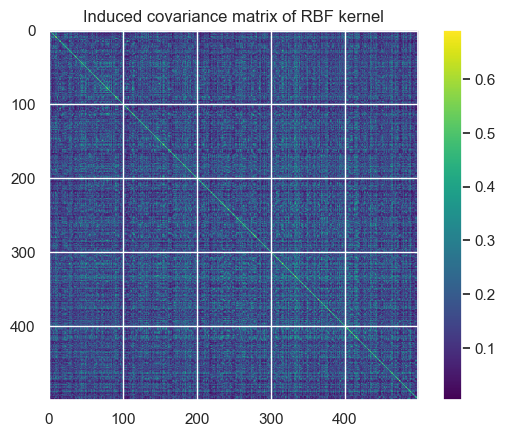

In [66]:
x_test_500 = x_test[:500]
y_test_500 = y_test[:500]

x_test_torch = torch.from_numpy(x_test_500).float()
y_test_torch = torch.from_numpy(y_test_500).float()

sorted_indices = torch.argsort(y_test_torch)
sorted_x_test_torch = x_test_torch[sorted_indices]

# sorted_x_test_torch = sorted_x_test_torch[:500]
# sorted_x_test_torch = sorted_x_test_torch[3500:]
# sorted_x_test_torch = sorted_x_test_torch[2000:2500]
# sorted_x_test_torch = x_test_torch

x_features = model.feature_extractor(sorted_x_test_torch)
cov_matrix = model.gp.get_covar(x_features).evaluate()

# Plot the induced covariance matrix
plt.imshow(cov_matrix.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Induced covariance matrix of RBF kernel")
plt.savefig('RBF_cov.pdf')


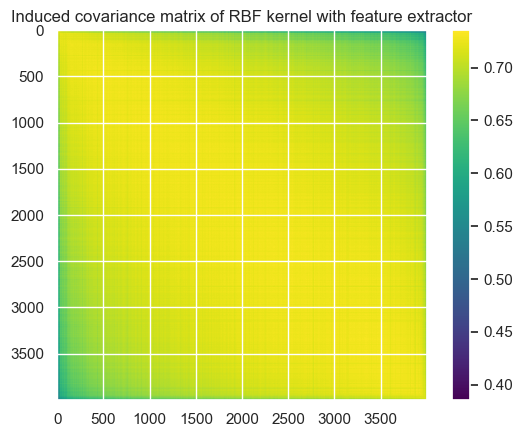

In [58]:
# x_test_500 = x_test[:500]
# y_test_500 = y_test[:500]

x_test_torch = torch.from_numpy(x_test).float()
y_test_torch = torch.from_numpy(y_test).float()

sorted_indices = torch.argsort(y_test_torch)
sorted_x_test_torch = x_test_torch[sorted_indices]

# sorted_x_test_torch = sorted_x_test_torch[:500]
# sorted_x_test_torch = sorted_x_test_torch[3500:]
# sorted_x_test_torch = sorted_x_test_torch[2000:2500]
# sorted_x_test_torch = x_test_torch

x_features = model.feature_extractor(sorted_x_test_torch)
cov_matrix = model.gp.get_covar(x_features).evaluate()

# Plot the induced covariance matrix
plt.imshow(cov_matrix.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Induced covariance matrix of RBF kernel with feature extractor")
plt.savefig('RBF_DKL_cov.pdf')


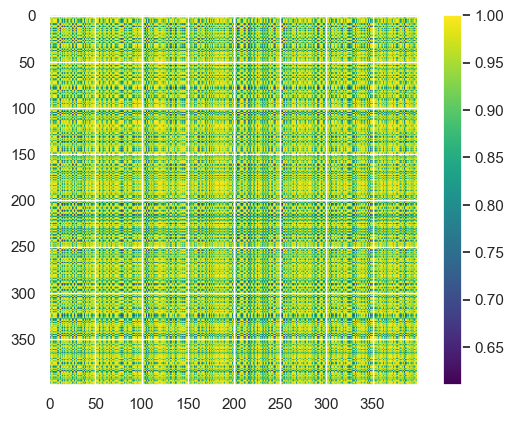

In [578]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_test and y_test are available as numpy arrays
# If they need to be loaded from a file, this would typically be done with numpy's loading functions.

# For the purpose of the example, let's create some dummy data
# np.random.seed(0)
# x_test = np.random.rand(400, 1) # 400 random data points
# y_test = np.random.rand(400) # 400 random target values

# Convert numpy arrays to torch tensors
x_test_torch = torch.from_numpy(x_test_500).float()
y_test_torch = torch.from_numpy(y_test_500).float()

# Sort x_test by the corresponding y_test values
sorted_indices = torch.argsort(y_test_torch)
sorted_x_test_torch = x_test_torch[sorted_indices]

# Placeholder for the model's covariance function
# In an actual use case, this would be replaced with the GP model's learned covariance function.
# def covariance_function(x1, x2):
#     # For demonstration, we'll use a simple squared exponential kernel
#     # In practice, this should be the kernel used by the GP model.
#     length_scale = 1.0
#     return torch.exp(-0.5 * ((x1 - x2) / length_scale).pow(2))



# Calculate the covariance matrix
cov_matrix = torch.zeros((100, 100), dtype=torch.float32)
for i in range(100):
    for j in range(100):
        
        cov_matrix[i, j] = covariance_function(sorted_x_test_torch[i], sorted_x_test_torch[j])

# Plot the induced covariance matrix
plt.imshow(cov_matrix, cmap='viridis')
plt.colorbar()
plt.show()


In [591]:
from gpytorch.kernels import ScaleKernel


self.covar_module = ScaleKernel(covariance_function, batch_shape=100)



AttributeError: 'function' object has no attribute 'active_dims'

In [ ]:
plt.xlim(-domain, domain)
plt.ylim(-10, 10)
plt.fill_between(x_lin, output - output_std, output + output_std, alpha=0.2, color='b')
plt.fill_between(x_lin, output - 2 * output_std, output + 2 * output_std, alpha=0.2, color='b')

plt.scatter([], [])
plt.scatter([], [])
X_vis, y_vis = make_data(n_samples=300)

plt.scatter(X_vis.squeeze(), y_vis, facecolors='none', edgecolors='g', linewidth=2)
plt.plot(x_lin, output, alpha=0.5)

In [ ]:
plt.xlim(-domain, domain)

for i in range(1):
    plt.plot(x_lin, ol.rsample().cpu(), alpha=0.3, color='b')
    
plt.scatter([], [])
plt.scatter([], [])
X_vis, y_vis = make_data(n_samples=200)
plt.scatter(X_vis.squeeze(), y_vis, s=50)

In [ ]:
# Inspired by https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
# only works on 1,000 samples

train_x, train_y = torch.tensor(x).float(), torch.tensor(y).float()

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = GaussianLikelihood()
exact_gp = ExactGPModel(train_x, train_y, likelihood)

exact_gp.train()
likelihood.train()

optimizer = torch.optim.Adam(exact_gp.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, exact_gp)

training_iter = 100

for i in range(training_iter):
    optimizer.zero_grad()
    output = exact_gp(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        exact_gp.covar_module.base_kernel.lengthscale.item(),
        exact_gp.likelihood.noise.item()
    ))
    optimizer.step()

In [ ]:
exact_gp.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-domain, domain, 100)
    observed_pred = likelihood(exact_gp(test_x))


    output = observed_pred.mean
    output_std = observed_pred.stddev

plt.xlim(-domain, domain)
plt.fill_between(x_lin, output - output_std, output + output_std, alpha=0.2, color='b')
plt.fill_between(x_lin, output - 2 * output_std, output + 2 * output_std, alpha=0.2, color='b')

plt.scatter([], [])
plt.scatter([], [])
X_vis, y_vis = make_data(n_samples=300)

plt.scatter(X_vis.squeeze(), y_vis, facecolors='none', edgecolors='g', linewidth=2)
plt.plot(x_lin, output, alpha=0.5)